# Predicting Archetypes with Earthformer
Loading the data

In [16]:
import numpy as np
import h5py
import xarray as xr

# import both nc's
stream_path = "../../../data/deseason_smsub_sqrtcosw/lentis_stream250_JJA_2deg_101_deseason_smsub_sqrtcosw.nc"
dataset_stream = xr.open_dataset(stream_path)

tas_path = "../../../data/deseason_smsub_sqrtcosw/lentis_tas_JJA_2deg_101_deseason.nc"
dataset_tas = xr.open_dataset(tas_path)

toa_path = "../../../data/deseason_smsub_sqrtcosw/lentis_toa_JJA_2deg_101_deseason.nc"
dataset_toa = xr.open_dataset(toa_path)

# get S_PCHA from archetypes file
with h5py.File('../../../data/deseason_smsub_sqrtcosw/pcha_results_8a_0d.hdf5', 'r') as f: # run from mmi393 directory or gives error
        S_PCHA = f['/S_PCHA'][:]

Join TAS and stream function data

In [57]:
def show_lat_values(time_sel, lon_sel, ds, varname):
    # Use method='nearest' to get the closest lon available
    ds_slice = ds[varname].isel(time=time_sel).sel(lon=lon_sel, method='nearest')

    # Create a dict of {lat_value: rlut_value}
    lat_var_map = {
        float(lat): float(ds_slice.sel(lat=lat, method='nearest').values)
        for lat in ds_slice['lat'].values
    }

    # Pretty print
    for lat, val in lat_var_map.items():
        print(f"{lat:.2f}°: {val:.2f}")


def align_ds_to_target_and_combine(olr_ds, stream_ds):
    target_lats = stream_ds['lat']
    spacing = np.mean(np.diff(target_lats))

    start = target_lats[0] - spacing
    n_points = 17
    new_lats = np.linspace(start, start - spacing * (n_points-1), n_points)
    extended_target_lats = np.concatenate([new_lats[::-1], target_lats])
    aligned_olr_ds = olr_ds.interp(lat=extended_target_lats, method='linear')

    stream_ds_ext = stream_ds.interp(lat=extended_target_lats, method='linear')
    stream_np = stream_ds_ext['stream'].squeeze('plev').values

    aligned_olr_jja = aligned_olr_ds.sel(time=aligned_olr_ds['time'].dt.month.isin([6, 7, 8]))
    olr_np = aligned_olr_jja['rlut'].values

    x_np = np.stack([stream_np, olr_np], axis=-1)
    
    return x_np

x_np = align_ds_to_target_and_combine(dataset_toa, dataset_stream)

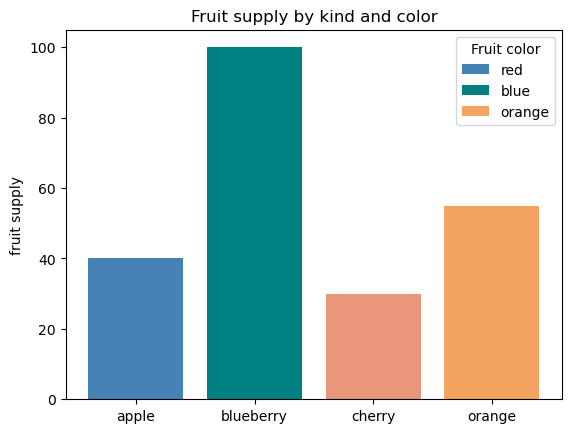

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

fruits = ['apple', 'blueberry', 'cherry', 'orange']
counts = [40, 100, 30, 55]
bar_labels = ['red', 'blue', '_red', 'orange']
bar_colors = ['steelblue', 'teal', 'darksalmon', 'sandybrown']

ax.bar(fruits, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel('fruit supply')
ax.set_title('Fruit supply by kind and color')
ax.legend(title='Fruit color')

plt.show()

In [69]:
import torch.nn.functional as F
import torch

print(x_np.shape)

def interpolate_tensor(x_tensor, target_size=(128, 128)):
    h,w = x_tensor.shape[1:3]
    print(f"w:{w}, h:{h}")
    target_w = target_size[1]
    scale = target_w/w
    target_h = int(round(h*scale))

    x_tensor_perm = x_tensor.permute(0, 3, 1, 2) # now T,C,H,W
    x_tensor_resized = F.interpolate(x_tensor_perm, size=(target_h, target_w), mode='bilinear', align_corners=False)
    x_tensor_resized = x_tensor_resized.permute(0, 2, 3, 1) # now T, H_new, W_new, C

    print(x_tensor_resized.shape)

    # Center the resized tensor along height
    out = torch.full((x_tensor.shape[0], target_size[0], target_size[1], x_tensor.shape[3]), float('nan'))
    top = (target_size[0] - target_h) // 2
    print(f"top: {top}")
    # print(f"top: {top}")

    out[:, top:top + target_h, :target_w, :] = x_tensor_resized
    print(out.shape)

interpolate_tensor(torch.from_numpy(x_np).float())


(9200, 46, 170, 2)
w:170, h:46
torch.Size([9200, 35, 128, 2])
top: 46
torch.Size([9200, 128, 128, 2])


In [9]:
# group indices based on whichever archetype is maximum there
arch_indices = np.argmax(S_PCHA, axis=0)

# sanity check part 1: these results should be the same in part 2
print(dataset_tas.isel(time=123)['tas'].isel(lon=0, lat=0).values)
print(dataset_tas.isel(time=74)['tas'].isel(lon=4, lat=8).values)

# join the nc's together
dataset_comb = dataset_stream.assign(tas=dataset_tas['tas'])

# sanity check part 2
print(dataset_comb.isel(time=123)['tas'].isel(lon=0, lat=0).values)
print(dataset_comb.isel(time=74)['tas'].isel(lon=4, lat=8).values)

-0.3480835
0.13922119
-0.3480835
0.13922119


Add labels from AA results

In [10]:
# sanity check 1
print(arch_indices[0], arch_indices[5], arch_indices[6], arch_indices[9119])

arch_da = xr.DataArray(arch_indices, dims="time", coords={"time": dataset_comb.time})
# sanity check 2 
print(arch_da.isel(time=0).values, arch_da.isel(time=5).values, arch_da.isel(time=6).values, arch_da.isel(time=9119).values)

# calculate the mean for each archetype's group
dataset_comb_labeled = dataset_comb.assign(archetype=arch_da)

# sanity check 3
print(dataset_comb_labeled.isel(time=0)['archetype'].values,
      dataset_comb_labeled.isel(time=5)['archetype'].values,
      dataset_comb_labeled.isel(time=6)['archetype'].values,
      dataset_comb_labeled.isel(time=9119)['archetype'].values)

4 2 2 3
4 2 2 3
4 2 2 3


## Dataset construction

In [11]:
import torch

/scistor/ivm/mmi393/.conda/envs/netcdf_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


From xarray dataset to pytorch tensors

In [12]:
stream = dataset_comb['stream'].squeeze('plev').values  # (T, lat, lon)
tas = dataset_comb['tas'].values                        # (T, lat, lon)

# Extract and squeeze stream function
stream = dataset_comb['stream'].squeeze('plev').values  # (T, H, W)
tas = dataset_comb['tas'].values                        # (T, H, W)

# Stack the variables along the channel axis
x_np = np.stack([stream, tas], axis=-1)  # shape: (T, H, W, C) where C = 2

# Convert to PyTorch tensor
x_tensor = torch.from_numpy(x_np).float()

print(x_tensor.shape)  # (T=9200, H=29, W=170, C=2)

torch.Size([9200, 29, 170, 2])


Target construction

If t+7 is belongs to another year, exclude example from labeling

In [13]:
from datetime import timedelta

l = 7  # lead time
time = dataset_comb['time'].values  # format: datetime64
arch_labels = arch_da.values        # (9200,)

x_all = x_tensor  # shape: (T, H, W, C)
x_list = []
y_list = []
kept_time_indices = []

# Makes it so that examples from different years do not get combined
# TODO Add data from September to include last week of August?
for t in range(len(time) - l):
    target_time = time[t] + np.timedelta64(l, 'D')
    if time[t + l] == target_time:
        x_list.append(x_all[t])
        y_list.append(arch_labels[t + l])
        kept_time_indices.append(t)

# Stack into tensors
x_final = torch.stack(x_list)              # shape: (N, H, W, C)
y_final = torch.tensor(y_list, dtype=torch.long)  # shape: (N,)

print(f"x_final shape: {x_final.shape}") # approx. 8% of the dataset is cut
print(f"y_final shape: {y_final.shape}")
print(kept_time_indices[:100])

x_final shape: torch.Size([8500, 29, 170, 2])
y_final shape: torch.Size([8500])
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106]


Train/Test Split

In [ ]:
# TODO split x&y into train/test sets

## Using Earthformer
Import pretrained Earthformer checkpoint for EarthNet2021

In [17]:
import os
from earthformer.cuboid_transformer.cuboid_transformer import CuboidTransformerModel
#from earthformer.train_cuboid_earthnet import CuboidEarthNet2021PLModule
from earthformer.utils.utils import download

save_dir = "./experiments"

pretrained_checkpoint_url = "https://earthformer.s3.amazonaws.com/pretrained_checkpoints/earthformer_earthnet2021.pt"
local_checkpoint_path = os.path.join(save_dir, "earthformer_earthnet2021.pt")
download(url=pretrained_checkpoint_url, path=local_checkpoint_path)

state_dict = torch.load(local_checkpoint_path, map_location=torch.device("cpu"))
#pl_module.torch_nn_module.load_state_dict(state_dict=state_dict)

Initialize Earthformer model with the correct config, based on Earthnet2021 setup in Earthformer github

In [15]:
earthformer_config = {
    "base_units": 256,
    "block_units": None,
    "scale_alpha": 1.0,

    "enc_depth": [1, 1],
    "dec_depth": [1, 1],
    "enc_use_inter_ffn": True,
    "dec_use_inter_ffn": True,
    "dec_hierarchical_pos_embed": False,

    "downsample": 2,
    "downsample_type": "patch_merge",
    "upsample_type": "upsample",

    "num_global_vectors": 2,
    "use_dec_self_global": False,
    "dec_self_update_global": True,
    "use_dec_cross_global": False,
    "use_global_vector_ffn": False,
    "use_global_self_attn": True,
    "separate_global_qkv": True,
    "global_dim_ratio": 1,

    "attn_drop": 0.1,
    "proj_drop": 0.1,
    "ffn_drop": 0.1,
    "num_heads": 4,

    "ffn_activation": "gelu",
    "gated_ffn": False,
    "norm_layer": "layer_norm",
    "padding_type": "zeros",
    "pos_embed_type": "t+hw",
    "use_relative_pos": True,
    "self_attn_use_final_proj": True,

    "checkpoint_level": 0,

    "initial_downsample_type": "stack_conv",
    "initial_downsample_activation": "leaky",
    "initial_downsample_stack_conv_num_layers": 2,
    "initial_downsample_stack_conv_dim_list": [64, 256],
    "initial_downsample_stack_conv_downscale_list": [2, 2],
    "initial_downsample_stack_conv_num_conv_list": [2, 2],

    "attn_linear_init_mode": "0",
    "ffn_linear_init_mode": "0",
    "conv_init_mode": "0",
    "down_up_linear_init_mode": "0",
    "norm_init_mode": "0",

    "dec_cross_last_n_frames": None
}

In [ ]:
# TODO figure out the proper initialization
# model = CuboidTransformerModel(input_shape=[10, 128, 128, 4],
#                                target_shape=[20, 128, 128, 4],
#                                **earthformer_config)

model = CuboidTransformerModel(input_shape=[1, 128, 128, 2],
                               target_shape=[1, 128, 128, 2],
                               **earthformer_config)

Load pretrained weights

In [ ]:
model_state_dict = model.state_dict()
# Filter the keys that match in name AND shape
compatible_state_dict = {}
for k, v in state_dict.items():
    if k in model_state_dict and model_state_dict[k].shape == v.shape:
        compatible_state_dict[k] = v
        # print(f"Loading: {k} | with shape: {v.shape}")
    else:
        val = model_state_dict.get(k, 'MISSING')
        if isinstance(val, torch.Tensor):
            val = val.shape
        print(f"Skipping: {k} | pretrained shape: {v.shape} vs model shape: {val}")

# load_result = model.load_state_dict(state_dict, strict=False)
# print("Missing keys:")
# print(load_result.missing_keys)
# print("Unexpected keys:")
# print(load_result.unexpected_keys)

Skipping: init_global_vectors | pretrained shape: torch.Size([8, 256]) vs model shape: torch.Size([2, 256])
Skipping: initial_aux_encoder.conv_block_list.0.0.weight | pretrained shape: torch.Size([64, 7, 3, 3]) vs model shape: MISSING
Skipping: initial_aux_encoder.conv_block_list.0.0.bias | pretrained shape: torch.Size([64]) vs model shape: MISSING
Skipping: initial_aux_encoder.conv_block_list.0.1.weight | pretrained shape: torch.Size([64]) vs model shape: MISSING
Skipping: initial_aux_encoder.conv_block_list.0.1.bias | pretrained shape: torch.Size([64]) vs model shape: MISSING
Skipping: initial_aux_encoder.conv_block_list.0.3.weight | pretrained shape: torch.Size([64, 64, 3, 3]) vs model shape: MISSING
Skipping: initial_aux_encoder.conv_block_list.0.3.bias | pretrained shape: torch.Size([64]) vs model shape: MISSING
Skipping: initial_aux_encoder.conv_block_list.0.4.weight | pretrained shape: torch.Size([64]) vs model shape: MISSING
Skipping: initial_aux_encoder.conv_block_list.0.4.bia

Adapt Earthformer to classification task

In [17]:
n_classes = S_PCHA.shape[0]

In [ ]:
class EarthformerClassifier(nn.Module):
    def __init__(self, earthformer_model, num_classes=n_classes):
        super().__init__()
        self.model = earthformer_model
        self.pool = nn.AdaptiveAvgPool3d((1, 1, 1))  # Pool over T, H, W
        self.classifier = nn.Linear(self.model.target_shape[-1], num_classes)

    def forward(self, x):
        x = self.model(x)  # (B, T_out, H, W, C_out)
        x = x.permute(0, 4, 1, 2, 3)  # → [B, C_out, T_out, H, W]
        x = self.pool(x).squeeze()    # → [B, C_out]
        logits = self.classifier(x)   # → [B, num_classes]
        probs = torch.sigmoid(logits) if logits.shape[1] == 1 else torch.softmax(logits, dim=1)
        return probs